In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib

In [2]:
print(tf.__version__)
SEED = 42
BATCH_SIZE = 32

2.3.1


In [3]:
data_path = '../data'
images_dir = pathlib.Path(f'{data_path}/images')
image_count = len(list(images_dir.glob('*/*.jpg')))
masks_dir = pathlib.Path(f'{data_path}/images_masks')
masks_count = len(list(masks_dir.glob('*.jpg')))

print(image_count, masks_count, image_count == masks_count)

17712 17712 True


In [4]:
list_ds = tf.data.Dataset.list_files(str(images_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
for f in list_ds.take(5):
    print(f.numpy())

b'../data/images/bad/825a8ea8f_4.jpg'
b'../data/images/good/433ee3ba0_13.jpg'
b'../data/images/good/ed9f593a2_2.jpg'
b'../data/images/good/674be7ddd_4.jpg'
b'../data/images/good/bea606041_11.jpg'


In [6]:
network_split = 0.6
validation_split = 0.2
ae_size = int(image_count * network_split)
ae_val_size = int(ae_size * validation_split)
conv_val_size = int((image_count-ae_size) * validation_split)
print(ae_size, ae_val_size, conv_val_size)
conv_ds = list_ds.skip(ae_size)
conv_train_ds = conv_ds.skip(conv_val_size)
conv_val_ds = conv_ds.take(conv_val_size)
ae_ds = list_ds.take(ae_size)
ae_train_ds = ae_ds.skip(ae_val_size)
ae_val_ds = ae_ds.take(ae_val_size)

10627 2125 1417


In [7]:
print(tf.data.experimental.cardinality(list_ds).numpy())
print(tf.data.experimental.cardinality(conv_ds).numpy())
print(tf.data.experimental.cardinality(conv_train_ds).numpy())
print(tf.data.experimental.cardinality(conv_val_ds).numpy())
print(tf.data.experimental.cardinality(ae_ds).numpy())
print(tf.data.experimental.cardinality(ae_train_ds).numpy())
print(tf.data.experimental.cardinality(ae_val_ds).numpy())

17712
7085
5668
1417
10627
8502
2125


In [8]:
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != ".gitkeep" and item.name != ".ipynb_checkpoints"]))
print(class_names)

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [256, 256])

def process_path_ae(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img

def process_path_conv(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = get_label(file_path)
    return img, label

['bad' 'good']


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
conv_train_ds = conv_train_ds.map(process_path_conv, num_parallel_calls=AUTOTUNE)
conv_val_ds = conv_val_ds.map(process_path_conv, num_parallel_calls=AUTOTUNE)
ae_train_ds = ae_train_ds.map(process_path_ae, num_parallel_calls=AUTOTUNE)
ae_val_ds = ae_val_ds.map(process_path_ae, num_parallel_calls=AUTOTUNE)

In [10]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

conv_train_ds = configure_for_performance(conv_train_ds) 
conv_val_ds = configure_for_performance(conv_val_ds) 
ae_train_ds = configure_for_performance(ae_train_ds) 
ae_val_ds = configure_for_performance(ae_val_ds) 

In [11]:
def save(ds, name):
    out_path = os.path.join(data_path, name)
    if os.path.exists(out_path):
        raise Exception('Path exists already')
    tf.data.experimental.save(ds, out_path)

In [12]:
save(conv_train_ds, 'conv_train_ds') 
save(conv_val_ds, 'conv_val_ds') 
save(ae_train_ds, 'ae_train_ds') 
save(ae_val_ds, 'ae_val_ds') 

In [13]:
# Element Specs
import pickle
elem_spec_conv = conv_train_ds.element_spec
elem_spec_ae = ae_train_ds.element_spec
print(f'Conv Spec:\n{elem_spec_conv}')
print(f'AE Spec:\n{elem_spec_ae}')
with open(os.path.join(data_path, 'specs.pickle'), 'wb') as f:
    pickle.dump((elem_spec_conv, elem_spec_ae), f)

Conv Spec:
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
AE Spec:
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


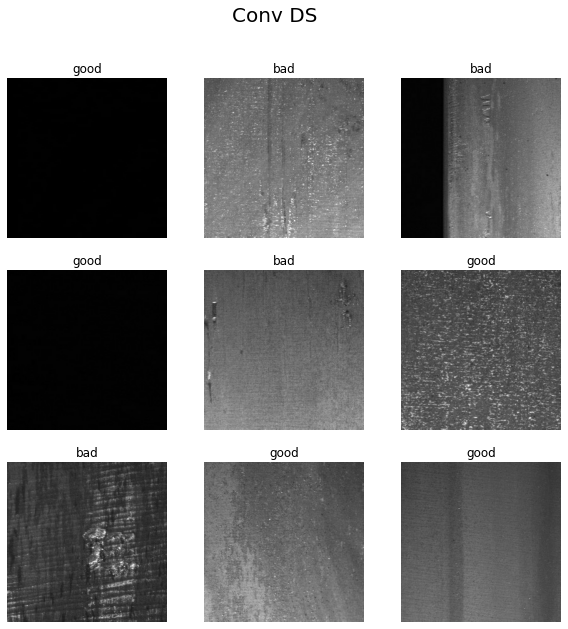

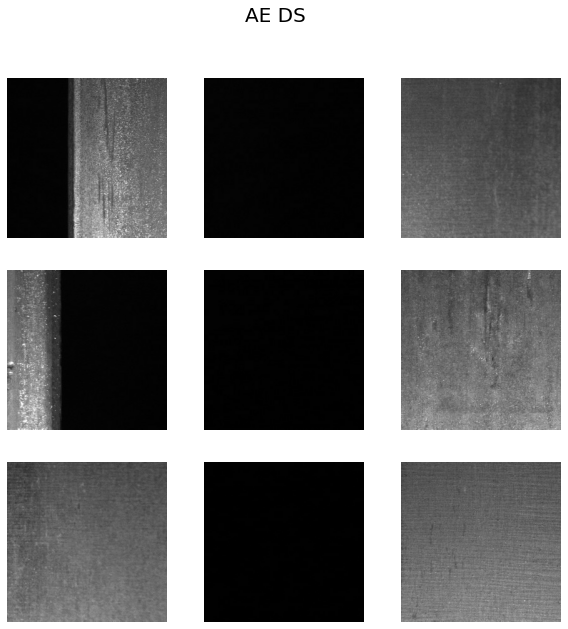

In [14]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(conv_val_ds))
X_batch, _ = next(iter(ae_val_ds))

def plot_conv_ds(image_batch, label_batch):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Conv DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")

def plot_ae_ds(image_batch):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('AE DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

plot_conv_ds(image_batch, label_batch)
plot_ae_ds(X_batch)

In [15]:
# Load
def load(name, spec):
    out_path = os.path.join(data_path, name)
    if not os.path.exists(out_path):
        raise Exception('Path does not exist')
    return tf.data.experimental.load(out_path, spec)

with open(os.path.join(data_path, 'specs.pickle'), 'rb') as f:
    spec_conv, spec_ae = pickle.load(f)
    
loaded_ae_val_ds = load('ae_val_ds', spec_ae)
loaded_conv_val_ds = load('conv_val_ds', spec_conv)

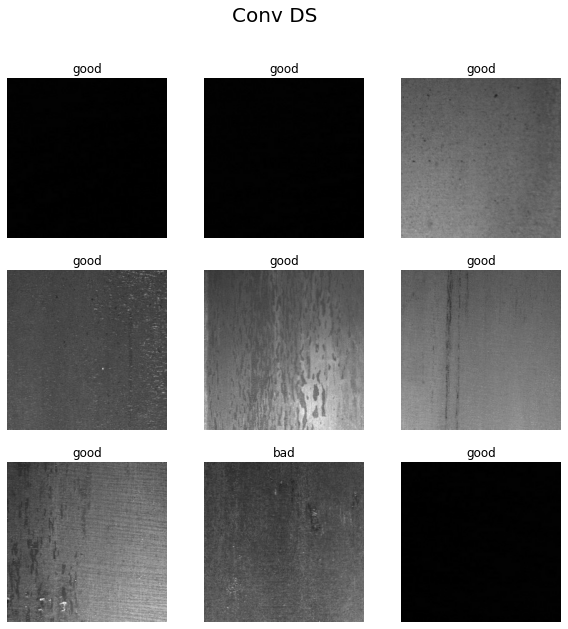

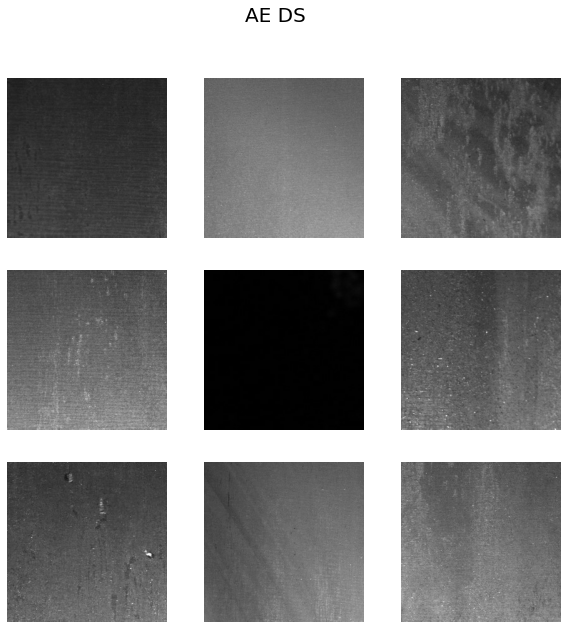

In [16]:
image_batch, label_batch = next(iter(loaded_conv_val_ds))
X_batch, _ = next(iter(loaded_ae_val_ds))

plot_conv_ds(image_batch, label_batch)
plot_ae_ds(X_batch)